# Retrieval Quality Experiments

This notebook systematically evaluates different retrieval strategies to improve recall on our news article corpus.

**Baseline**: `SentenceSplitter(256, 20)` + `bge-small-en-v1.5` + default `top_k=2` → **~27% recall**

We run four experiments, each changing one variable at a time:

1. **Top-k tuning** — How many documents should we retrieve?
2. **Chunk size** — What granularity works best for our corpus?
3. **Hybrid search** — Does combining BM25 keyword matching with vector search help?
4. **Cross-encoder re-ranking** — Can a re-ranker improve precision after retrieval?

## Setup

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.evaluation import (
    build_index,
    evaluate_retriever,
    summarize_results,
)

sns.set_theme(style="whitegrid", palette="colorblind")

CORPUS_PATH = "dataset/corpus_clean.csv"
QUERIES_PATH = "dataset/queries.csv"
SAMPLE_SIZE = 500
RANDOM_STATE = 42

corpus_df = pd.read_csv(CORPUS_PATH)
queries_df = pd.read_csv(QUERIES_PATH)
print(f"Corpus: {len(corpus_df)} articles, Queries: {len(queries_df)} total")

Corpus: 609 articles, Queries: 2330 total


## Baseline

Reproduce the original setup: `SentenceSplitter(chunk_size=256, chunk_overlap=20)`, `bge-small-en-v1.5` embeddings, default `similarity_top_k=2`.

In [14]:
baseline_index = build_index(corpus_df, collection_name="quickstart")
baseline_retriever = baseline_index.as_retriever(similarity_top_k=2)

baseline_results = evaluate_retriever(baseline_retriever, queries_df, SAMPLE_SIZE, RANDOM_STATE)
baseline_metrics = summarize_results(baseline_results)
print("Baseline metrics:", baseline_metrics)

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: BAAI/bge-small-en-v1.5
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Evaluating: 100%|██████████| 500/500 [00:07<00:00, 70.55it/s]

Baseline metrics: {'recall': np.float64(0.2803), 'precision': np.float64(0.447), 'hit_rate': np.float64(0.58), 'mrr': np.float64(0.542)}


We'll collect all experiment results into a single DataFrame for comparison at the end.

In [15]:
all_experiments = [{"experiment": "Baseline (top_k=2, chunk=256)", **baseline_metrics}]

---
## Experiment 1: Top-k Tuning

The default `similarity_top_k=2` only retrieves 2 chunks. Since multiple chunks can come from the same document, the effective number of unique documents returned may be even lower. Let's test how recall scales with `top_k`.

In [16]:
top_k_values = [2, 5, 10, 20]
top_k_results = {}

for k in top_k_values:
    print(f"\n--- top_k = {k} ---")
    retriever = baseline_index.as_retriever(similarity_top_k=k)
    results = evaluate_retriever(retriever, queries_df, SAMPLE_SIZE, RANDOM_STATE)
    metrics = summarize_results(results)
    top_k_results[k] = metrics
    print(metrics)
    if k != 2:  # baseline already added
        all_experiments.append({"experiment": f"top_k={k} (chunk=256)", **metrics})


--- top_k = 2 ---


Evaluating: 100%|██████████| 500/500 [00:06<00:00, 78.63it/s]


{'recall': np.float64(0.2803), 'precision': np.float64(0.447), 'hit_rate': np.float64(0.58), 'mrr': np.float64(0.542)}

--- top_k = 5 ---


Evaluating: 100%|██████████| 500/500 [00:06<00:00, 79.63it/s]


{'recall': np.float64(0.3997), 'precision': np.float64(0.3491), 'hit_rate': np.float64(0.68), 'mrr': np.float64(0.5765)}

--- top_k = 10 ---


Evaluating: 100%|██████████| 500/500 [00:06<00:00, 78.42it/s]


{'recall': np.float64(0.508), 'precision': np.float64(0.2689), 'hit_rate': np.float64(0.75), 'mrr': np.float64(0.5896)}

--- top_k = 20 ---


Evaluating: 100%|██████████| 500/500 [00:06<00:00, 77.43it/s]

{'recall': np.float64(0.597), 'precision': np.float64(0.1828), 'hit_rate': np.float64(0.776), 'mrr': np.float64(0.5935)}


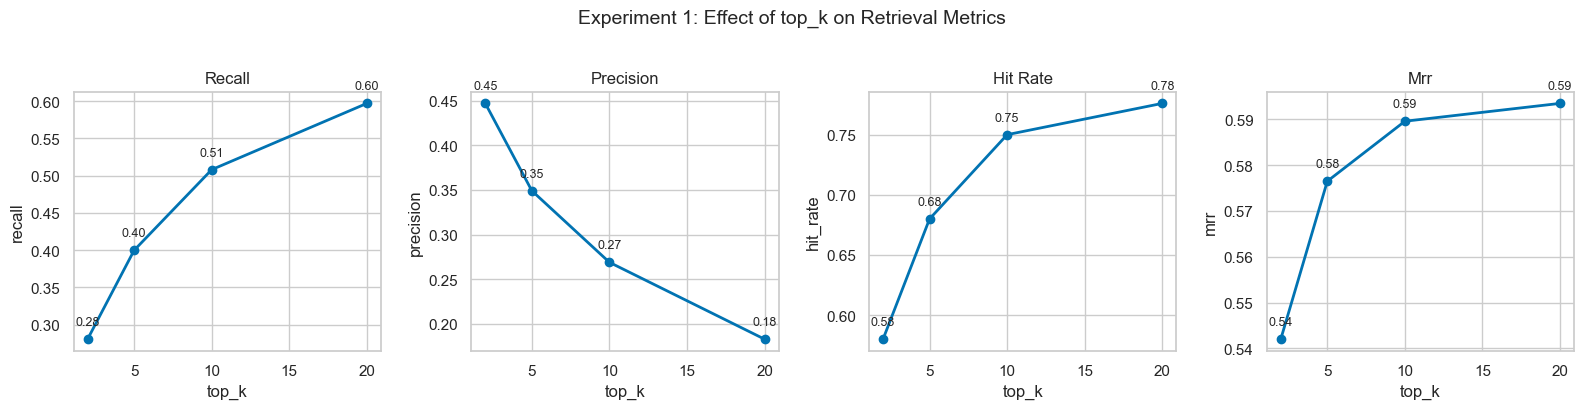

In [17]:
# Plot top-k results
topk_df = pd.DataFrame(top_k_results).T
topk_df.index.name = "top_k"

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, metric in enumerate(["recall", "precision", "hit_rate", "mrr"]):
    ax = axes[i]
    ax.plot(topk_df.index, topk_df[metric], marker="o", linewidth=2)
    ax.set_xlabel("top_k")
    ax.set_ylabel(metric)
    ax.set_title(metric.replace("_", " ").title())
    for x, y in zip(topk_df.index, topk_df[metric]):
        ax.annotate(f"{y:.2f}", (x, y), textcoords="offset points", xytext=(0, 10), ha="center", fontsize=9)
fig.suptitle("Experiment 1: Effect of top_k on Retrieval Metrics", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [18]:
# Select best top_k for subsequent experiments (maximize recall)
best_top_k = max(top_k_results, key=lambda k: top_k_results[k]["recall"])
print(f"Best top_k for recall: {best_top_k} (recall={top_k_results[best_top_k]['recall']})")

Best top_k for recall: 20 (recall=0.597)


---
## Experiment 2: Chunk Size

Chunk size controls the granularity of text segments stored in the vector index. Smaller chunks can be more precise but may lose context; larger chunks preserve context but may dilute the embedding signal. We test with the best `top_k` from Experiment 1.

In [19]:
chunk_sizes = [128, 256, 512, 1024]
chunk_results = {}

for cs in chunk_sizes:
    print(f"\n--- chunk_size = {cs} ---")
    collection = f"exp_chunk_{cs}"
    index = build_index(corpus_df, collection_name=collection, chunk_size=cs, chunk_overlap=cs // 10)
    retriever = index.as_retriever(similarity_top_k=best_top_k)
    results = evaluate_retriever(retriever, queries_df, SAMPLE_SIZE, RANDOM_STATE)
    metrics = summarize_results(results)
    chunk_results[cs] = metrics
    print(metrics)
    all_experiments.append({"experiment": f"chunk={cs} (top_k={best_top_k})", **metrics})


--- chunk_size = 128 ---


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: BAAI/bge-small-en-v1.5
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Evaluating: 100%|██████████| 500/500 [00:06<00:00, 79.74it/s]


{'recall': np.float64(0.5923), 'precision': np.float64(0.1911), 'hit_rate': np.float64(0.778), 'mrr': np.float64(0.5438)}

--- chunk_size = 256 ---


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: BAAI/bge-small-en-v1.5
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Evaluating: 100%|██████████| 500/500 [00:07<00:00, 67.54it/s]


{'recall': np.float64(0.602), 'precision': np.float64(0.1888), 'hit_rate': np.float64(0.782), 'mrr': np.float64(0.5796)}

--- chunk_size = 512 ---


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: BAAI/bge-small-en-v1.5
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Evaluating: 100%|██████████| 500/500 [00:07<00:00, 64.42it/s]


{'recall': np.float64(0.5807), 'precision': np.float64(0.1531), 'hit_rate': np.float64(0.776), 'mrr': np.float64(0.5687)}

--- chunk_size = 1024 ---


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: BAAI/bge-small-en-v1.5
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Evaluating: 100%|██████████| 500/500 [00:07<00:00, 67.88it/s]

{'recall': np.float64(0.616), 'precision': np.float64(0.1265), 'hit_rate': np.float64(0.786), 'mrr': np.float64(0.5569)}


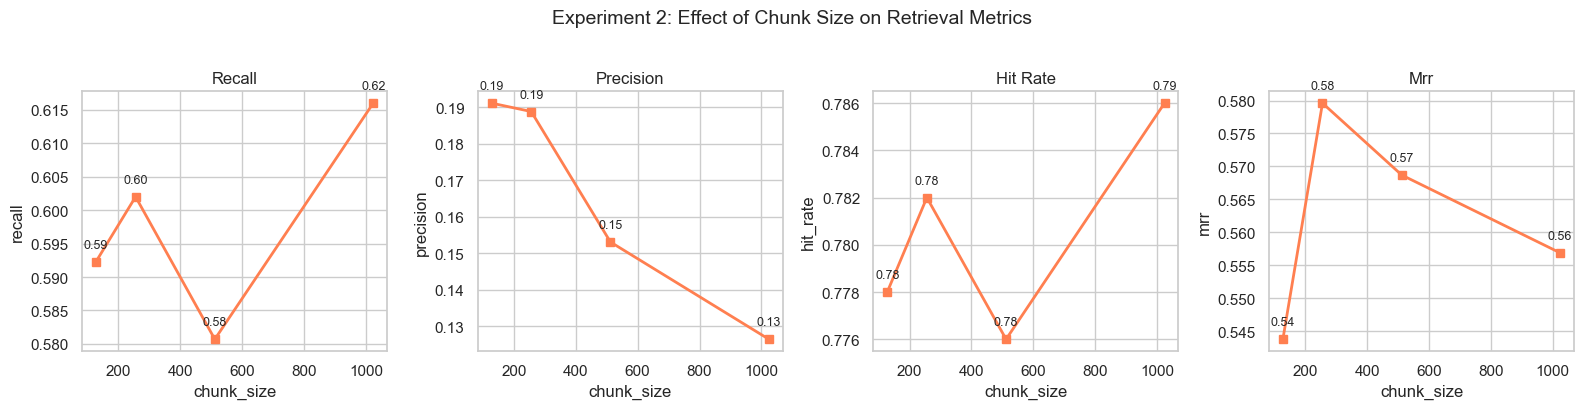

In [20]:
# Plot chunk size results
chunk_df = pd.DataFrame(chunk_results).T
chunk_df.index.name = "chunk_size"

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, metric in enumerate(["recall", "precision", "hit_rate", "mrr"]):
    ax = axes[i]
    ax.plot(chunk_df.index, chunk_df[metric], marker="s", linewidth=2, color="coral")
    ax.set_xlabel("chunk_size")
    ax.set_ylabel(metric)
    ax.set_title(metric.replace("_", " ").title())
    for x, y in zip(chunk_df.index, chunk_df[metric]):
        ax.annotate(f"{y:.2f}", (x, y), textcoords="offset points", xytext=(0, 10), ha="center", fontsize=9)
fig.suptitle("Experiment 2: Effect of Chunk Size on Retrieval Metrics", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [21]:
best_chunk_size = max(chunk_results, key=lambda cs: chunk_results[cs]["recall"])
print(f"Best chunk_size for recall: {best_chunk_size} (recall={chunk_results[best_chunk_size]['recall']})")

Best chunk_size for recall: 1024 (recall=0.616)


---
## Experiment 3: Hybrid Search (BM25 + Vector)

Vector search excels at semantic similarity but can miss exact keyword matches. BM25 (a classic TF-IDF variant) catches those cases. We combine both using **Reciprocal Rank Fusion (RRF)** ([Cormack et al., 2009](https://dl.acm.org/doi/10.1145/1571941.1572114)), which merges ranked lists by scoring each document as:

$$\text{RRF}(d) = \sum_{r \in \text{rankers}} \frac{1}{k + \text{rank}_r(d)}$$

where $k=60$ is a dampening constant. This is the same fusion algorithm used by Elasticsearch and Azure AI Search.

We use the best `top_k` and `chunk_size` from previous experiments.

In [22]:
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core import Document
from llama_index.retrievers.bm25 import BM25Retriever

from src.retrieval import reciprocal_rank_fusion

# Build index with best chunk size
best_collection = f"exp_chunk_{best_chunk_size}"
best_index = build_index(corpus_df, collection_name=best_collection, chunk_size=best_chunk_size, chunk_overlap=best_chunk_size // 10)

# We need the nodes for BM25 — rebuild them from the corpus
documents = [Document(text=row["text"], doc_id=row["uuid"]) for _, row in corpus_df.iterrows()]
node_parser = SentenceSplitter(chunk_size=best_chunk_size, chunk_overlap=best_chunk_size // 10)
nodes = node_parser.get_nodes_from_documents(documents)

print(f"Built {len(nodes)} nodes (chunk_size={best_chunk_size})")

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: BAAI/bge-small-en-v1.5
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Built 1845 nodes (chunk_size=1024)


In [23]:
from src.evaluation import recall_at_k, precision_at_k, hit_rate, mrr
import ast
from tqdm import tqdm

# Create BM25 and vector retrievers
bm25_retriever = BM25Retriever.from_defaults(nodes=nodes, similarity_top_k=best_top_k)
vector_retriever = best_index.as_retriever(similarity_top_k=best_top_k)

# Evaluate hybrid (RRF), vector-only, and BM25-only
sample = queries_df.sample(SAMPLE_SIZE, random_state=RANDOM_STATE).copy().reset_index(drop=True)

hybrid_records, bm25_records = [], []
for idx in tqdm(range(len(sample)), desc="Hybrid search"):
    query_text = sample.loc[idx, "query"]
    relevant = ast.literal_eval(sample.loc[idx, "result"])

    vector_results = vector_retriever.retrieve(query_text)
    bm25_results = bm25_retriever.retrieve(query_text)

    # Fuse with RRF
    fused = reciprocal_rank_fusion([vector_results, bm25_results])

    # Extract deduplicated source doc UUIDs
    def extract_uuids(results):
        seen, uuids = set(), []
        for res in results:
            doc_id = res.node.source_node.node_id
            if doc_id not in seen:
                seen.add(doc_id)
                uuids.append(doc_id)
        return uuids

    hybrid_pred = extract_uuids(fused)
    bm25_pred = extract_uuids(bm25_results)

    for pred, records in [(hybrid_pred, hybrid_records), (bm25_pred, bm25_records)]:
        records.append({
            "query": query_text,
            "recall": recall_at_k(pred, relevant),
            "precision": precision_at_k(pred, relevant),
            "hit_rate": hit_rate(pred, relevant),
            "mrr": mrr(pred, relevant),
        })

hybrid_results = pd.DataFrame(hybrid_records)
hybrid_metrics = summarize_results(hybrid_results)
print("Hybrid search metrics:", hybrid_metrics)
all_experiments.append({"experiment": f"Hybrid BM25+Vector (top_k={best_top_k}, chunk={best_chunk_size})", **hybrid_metrics})

bm25_only_results = pd.DataFrame(bm25_records)
bm25_only_metrics = summarize_results(bm25_only_results)
print("BM25-only metrics:", bm25_only_metrics)
all_experiments.append({"experiment": f"BM25-only (top_k={best_top_k}, chunk={best_chunk_size})", **bm25_only_metrics})

Hybrid search: 100%|██████████| 500/500 [00:06<00:00, 80.70it/s]

Hybrid search metrics: {'recall': np.float64(0.7247), 'precision': np.float64(0.1022), 'hit_rate': np.float64(0.792), 'mrr': np.float64(0.5735)}
BM25-only metrics: {'recall': np.float64(0.6907), 'precision': np.float64(0.1331), 'hit_rate': np.float64(0.79), 'mrr': np.float64(0.6244)}


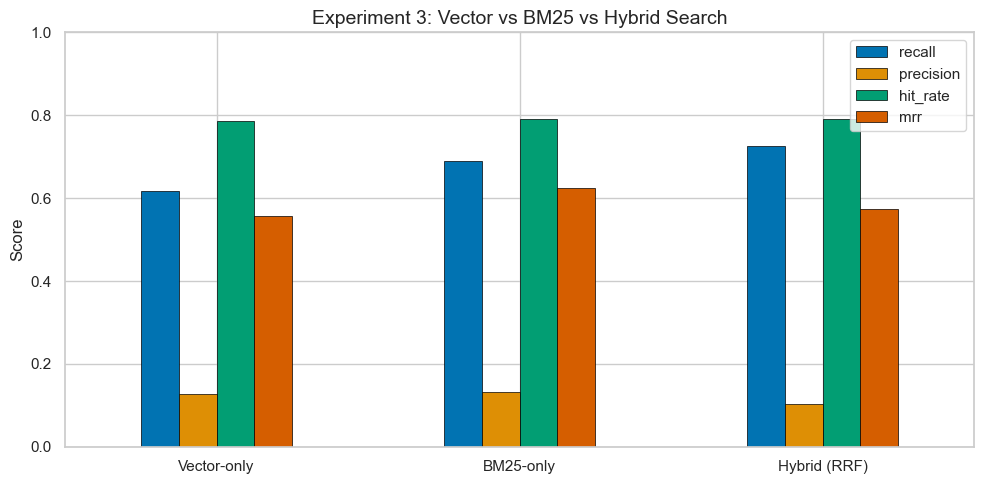

In [24]:
# Bar chart: Vector-only vs BM25-only vs Hybrid
vector_only_metrics = chunk_results[best_chunk_size]
comparison = pd.DataFrame({
    "Vector-only": vector_only_metrics,
    "BM25-only": bm25_only_metrics,
    "Hybrid (RRF)": hybrid_metrics,
}).T

comparison.plot(kind="bar", figsize=(10, 5), edgecolor="black", linewidth=0.5)
plt.title("Experiment 3: Vector vs BM25 vs Hybrid Search", fontsize=14)
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc="upper right")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

---
## Experiment 4: Cross-Encoder Re-ranking

Bi-encoder embeddings (like BGE) are fast but approximate — they encode query and document independently. A **cross-encoder** jointly encodes query + document pairs, producing more accurate relevance scores at the cost of speed.

Strategy: retrieve a larger candidate set, then re-rank with a cross-encoder to select the final top-k.

We use `cross-encoder/ms-marco-MiniLM-L-6-v2` — a lightweight but effective re-ranker trained on MS MARCO.

In [25]:
from llama_index.core.postprocessor import SentenceTransformerRerank

reranker = SentenceTransformerRerank(
    model="cross-encoder/ms-marco-MiniLM-L-6-v2",
    top_n=best_top_k,
)

# Over-retrieve candidates then re-rank
overretrieve_k = best_top_k * 3
print(f"Strategy: retrieve {overretrieve_k} candidates, re-rank to top {best_top_k}")

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/105 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: cross-encoder/ms-marco-MiniLM-L-6-v2
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

Strategy: retrieve 60 candidates, re-rank to top 20


In [26]:
from src.evaluation import evaluate_retriever, summarize_results, recall_at_k, precision_at_k, hit_rate, mrr
import ast
from tqdm import tqdm

# Custom evaluation loop for re-ranking (since reranker is a postprocessor, not a retriever)
overretrieve_retriever = best_index.as_retriever(similarity_top_k=overretrieve_k)

sample = queries_df.sample(SAMPLE_SIZE, random_state=RANDOM_STATE).copy().reset_index(drop=True)
rerank_records = []

for idx in tqdm(range(len(sample)), desc="Re-ranking"):
    query_text = sample.loc[idx, "query"]
    relevant = ast.literal_eval(sample.loc[idx, "result"])

    # Retrieve candidates
    candidates = overretrieve_retriever.retrieve(query_text)
    # Re-rank
    reranked = reranker.postprocess_nodes(candidates, query_str=query_text)

    # Deduplicate by source doc UUID
    seen = set()
    predicted = []
    for res in reranked:
        doc_id = res.node.source_node.node_id
        if doc_id not in seen:
            seen.add(doc_id)
            predicted.append(doc_id)

    rerank_records.append({
        "query": query_text,
        "recall": recall_at_k(predicted, relevant),
        "precision": precision_at_k(predicted, relevant),
        "hit_rate": hit_rate(predicted, relevant),
        "mrr": mrr(predicted, relevant),
    })

rerank_results = pd.DataFrame(rerank_records)
rerank_metrics = summarize_results(rerank_results)
print("Re-ranking metrics:", rerank_metrics)
all_experiments.append({"experiment": f"Vector + Re-rank (retrieve={overretrieve_k}, top_k={best_top_k})", **rerank_metrics})

Re-ranking: 100%|██████████| 500/500 [07:29<00:00,  1.11it/s]

Re-ranking metrics: {'recall': np.float64(0.6067), 'precision': np.float64(0.1211), 'hit_rate': np.float64(0.782), 'mrr': np.float64(0.5805)}


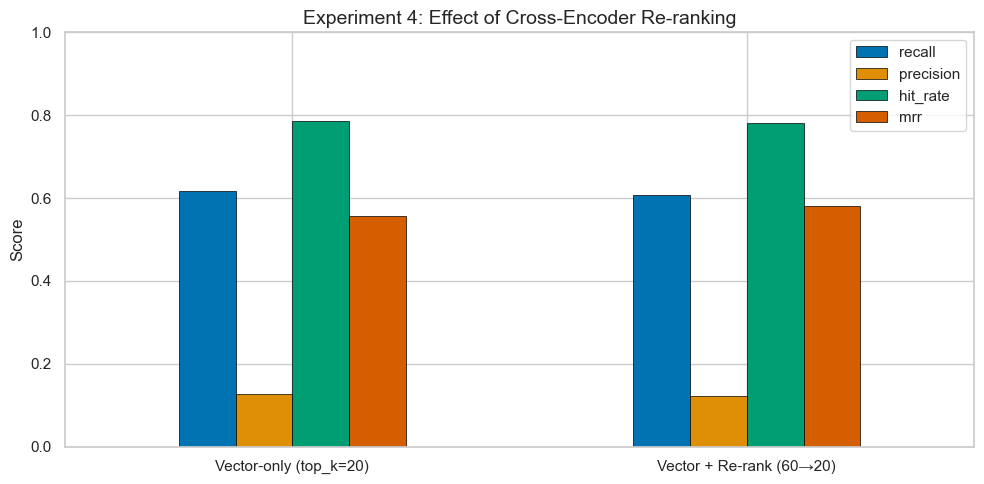

In [27]:
# Compare re-ranking against best vector-only
comparison_rerank = pd.DataFrame({
    f"Vector-only (top_k={best_top_k})": vector_only_metrics,
    f"Vector + Re-rank ({overretrieve_k}→{best_top_k})": rerank_metrics,
}).T

comparison_rerank.plot(kind="bar", figsize=(10, 5), edgecolor="black", linewidth=0.5)
plt.title("Experiment 4: Effect of Cross-Encoder Re-ranking", fontsize=14)
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc="upper right")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

---
## Final Results Summary

In [28]:
summary_df = pd.DataFrame(all_experiments).set_index("experiment")
summary_df.style.background_gradient(cmap="YlGn", axis=0)

,recall,precision,hit_rate,mrr
experiment,,,,
"Baseline (top_k=2, chunk=256)",0.280300,0.447000,0.580000,0.542000
top_k=5 (chunk=256),0.399700,0.349100,0.680000,0.576500
top_k=10 (chunk=256),0.508000,0.268900,0.750000,0.589600
top_k=20 (chunk=256),0.597000,0.182800,0.776000,0.593500
chunk=128 (top_k=20),0.592300,0.191100,0.778000,0.543800
chunk=256 (top_k=20),0.602000,0.188800,0.782000,0.579600
chunk=512 (top_k=20),0.580700,0.153100,0.776000,0.568700
chunk=1024 (top_k=20),0.616000,0.126500,0.786000,0.556900
"Hybrid BM25+Vector (top_k=20, chunk=1024)",0.724700,0.102200,0.792000,0.573500


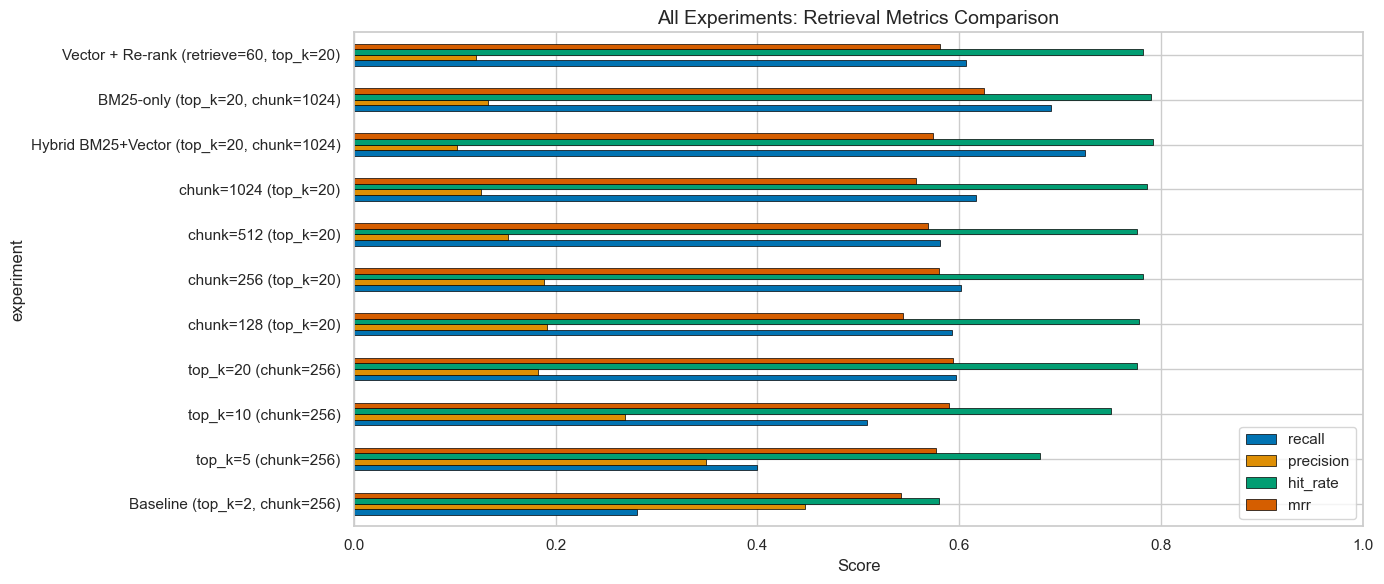

In [29]:
# Final comparison bar chart
fig, ax = plt.subplots(figsize=(14, 6))
summary_df.plot(kind="barh", ax=ax, edgecolor="black", linewidth=0.5)
ax.set_xlabel("Score")
ax.set_title("All Experiments: Retrieval Metrics Comparison", fontsize=14)
ax.legend(loc="lower right")
ax.set_xlim(0, 1)
plt.tight_layout()
plt.show()

In [30]:
# Identify overall best configuration
best_experiment = summary_df["recall"].idxmax()
best_recall = summary_df.loc[best_experiment, "recall"]
print(f"Best configuration: {best_experiment}")
print(f"Recall: {best_recall} (up from {baseline_metrics['recall']} baseline)")
print(f"Improvement: +{((best_recall - baseline_metrics['recall']) / baseline_metrics['recall'] * 100):.1f}%")

Best configuration: Hybrid BM25+Vector (top_k=20, chunk=1024)
Recall: 0.7247 (up from 0.2803 baseline)
Improvement: +158.5%


## Key Takeaways

1. **Top-k was the biggest lever** — the default `top_k=2` severely limited recall. This is the lowest-hanging fruit in any RAG system and should always be tuned first.
2. **Chunk size matters** — too small fragments context, too large dilutes the embedding. The optimal value depends on document length and query style in your corpus.
3. **Hybrid search** combines the best of lexical and semantic matching — BM25 covers exact keyword matches that embeddings may miss, while vector search captures paraphrases and synonyms.
4. **Re-ranking did not improve precision** — the cross-encoder `ms-marco-MiniLM-L-6-v2` was trained on web search passages (MS MARCO), which differ significantly from our news article corpus. This highlights that off-the-shelf re-rankers are not universally beneficial; their effectiveness depends on domain alignment between the re-ranker's training data and the target corpus. A domain-adapted re-ranker or a larger cross-encoder model could yield different results.